# Predicting the Listing Price of Airbnb Stays in Europe

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import pointbiserialr
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from xgboost import XGBRegressor
from typing import Union

## 1. EDA

Objectives: 
- Checking for discrepancies
- Compare differences between cities
- Inspect distribution of feature columns

In [2]:
airbnb = pd.read_csv('Aemf1.csv')

#changing european spelling is a personal preference here. 
airbnb.columns = (
    airbnb.columns.str.lower()
    .str.replace(' ', '_')
    .str.replace('restraunt', 'restaurant')
    .str.replace('normalised', 'normalized')
)
airbnb.head()

,city,price,day,room_type,shared_room,private_room,person_capacity,superhost,multiple_rooms,business,cleanliness_rating,guest_satisfaction,bedrooms,city_center_(km),metro_distance_(km),attraction_index,normalized_attraction_index,restaurant_index,normalized_restaurant_index
0,Amsterdam,194.033698,Weekday,Private room,False,True,2,False,1,0,10,93,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473
1,Amsterdam,344.245776,Weekday,Private room,False,True,4,False,0,0,8,85,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928
2,Amsterdam,264.101422,Weekday,Private room,False,True,2,False,0,1,9,87,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700
3,Amsterdam,433.529398,Weekday,Private room,False,True,4,False,0,1,9,90,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565
4,Amsterdam,485.552926,Weekday,Private room,False,True,2,True,0,0,10,98,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677


In [3]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41714 entries, 0 to 41713
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   city                         41714 non-null  object 
 1   price                        41714 non-null  float64
 2   day                          41714 non-null  object 
 3   room_type                    41714 non-null  object 
 4   shared_room                  41714 non-null  bool   
 5   private_room                 41714 non-null  bool   
 6   person_capacity              41714 non-null  int64  
 7   superhost                    41714 non-null  bool   
 8   multiple_rooms               41714 non-null  int64  
 9   business                     41714 non-null  int64  
 10  cleanliness_rating           41714 non-null  int64  
 11  guest_satisfaction           41714 non-null  int64  
 12  bedrooms                     41714 non-null  int64  
 13  city_center_(km)

In [4]:
#confirming no null/duplicate values
print(airbnb.isna().sum())
airbnb[airbnb.duplicated() == True]

city                           0
price                          0
day                            0
room_type                      0
shared_room                    0
private_room                   0
person_capacity                0
superhost                      0
multiple_rooms                 0
business                       0
cleanliness_rating             0
guest_satisfaction             0
bedrooms                       0
city_center_(km)               0
metro_distance_(km)            0
attraction_index               0
normalized_attraction_index    0
restaurant_index               0
normalized_restaurant_index    0
dtype: int64


,city,price,day,room_type,shared_room,private_room,person_capacity,superhost,multiple_rooms,business,cleanliness_rating,guest_satisfaction,bedrooms,city_center_(km),metro_distance_(km),attraction_index,normalized_attraction_index,restaurant_index,normalized_restaurant_index


In [5]:
#we can get the bool columns to int as they are in other places
bool_cols = ['shared_room', 'private_room', 'superhost']
for col in bool_cols:
    airbnb[col] = airbnb[col].astype(int)

In [6]:
airbnb.nunique()

city                               9
price                           8087
day                                2
room_type                          3
shared_room                        2
private_room                       2
person_capacity                    5
superhost                          2
multiple_rooms                     2
business                           2
cleanliness_rating                 9
guest_satisfaction                51
bedrooms                           9
city_center_(km)               41713
metro_distance_(km)            41713
attraction_index               41712
normalized_attraction_index    41696
restaurant_index               41711
normalized_restaurant_index    41697
dtype: int64

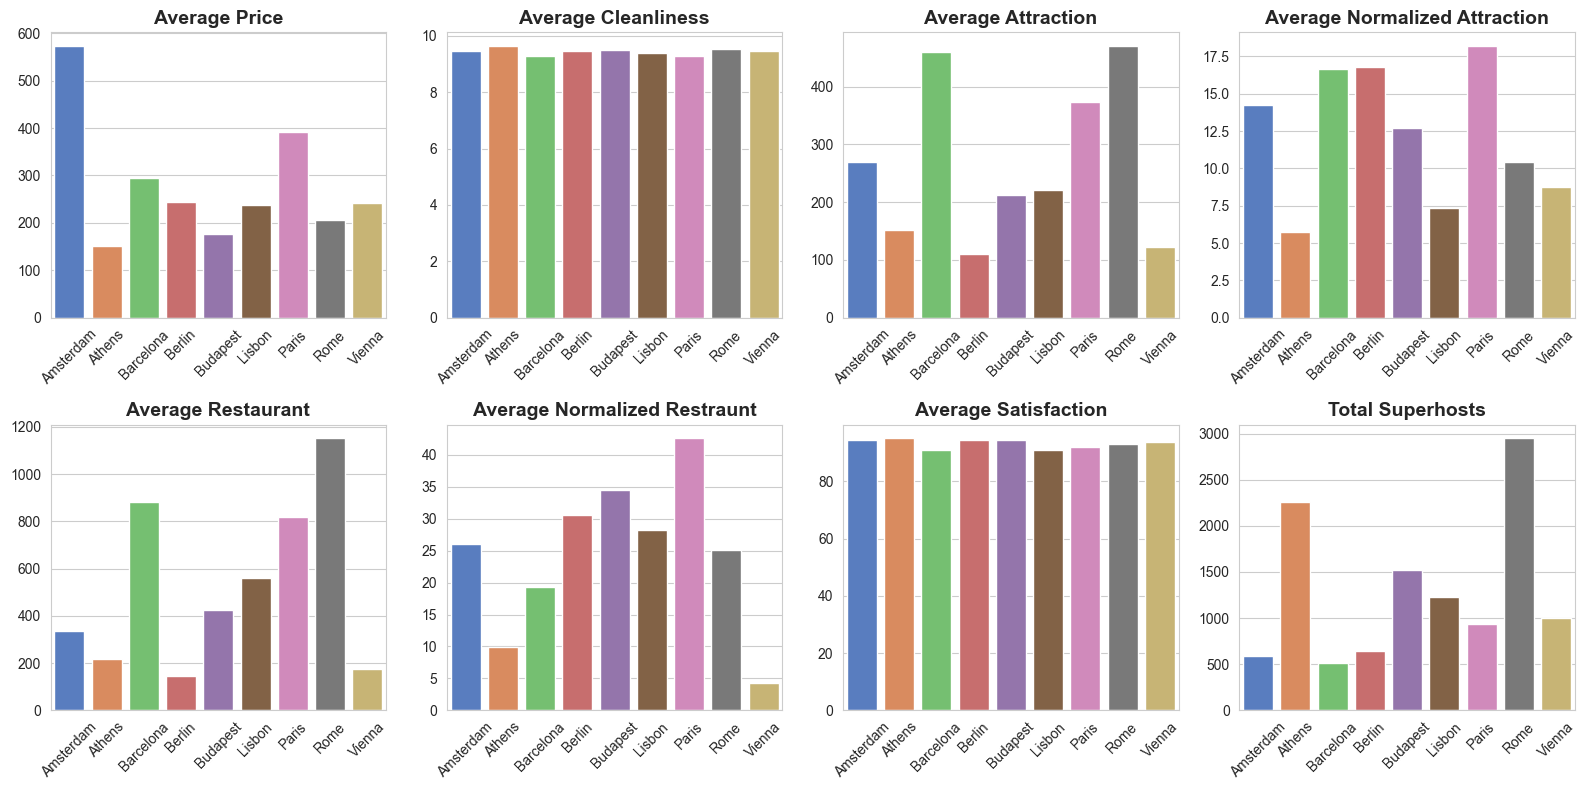

In [7]:
sns.set_palette('muted')
sns.set_style('whitegrid')

airbnb_grouped = airbnb.groupby('city').agg(
    avg_price=('price', 'mean'), 
    avg_cleanliness=('cleanliness_rating', 'mean'),
    avg_attraction=('attraction_index', 'mean'),
    avg_normalized_attraction=('normalized_attraction_index', 'mean'),
    avg_restaurant=('restaurant_index', 'mean'),
    avg_normalized_restraunt=('normalized_restaurant_index', 'mean'),
    avg_satisfaction=('guest_satisfaction', 'mean'),
    total_superhosts=('superhost', 'sum')
    ).reset_index()

cols_to_plot = airbnb_grouped.columns[1:]

plt.figure(figsize=(16,8))

for i, column in enumerate(cols_to_plot):
    plt.subplot(2,4,i+1)
    sns.barplot(x='city', y=column, data=airbnb_grouped, hue='city')
    col_title = column.replace('avg', 'Average').replace('_', ' ').title()
    plt.title(col_title, fontsize=14, weight='bold')
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()


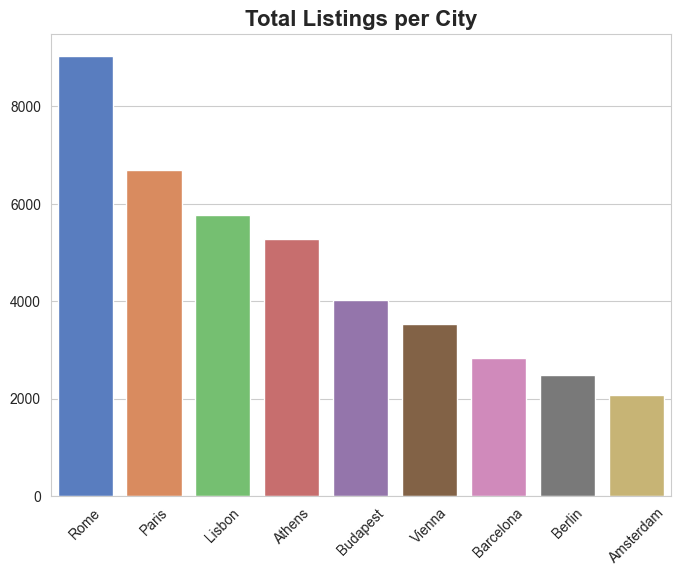

In [8]:
city_count = airbnb['city'].value_counts().to_frame().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='city', y='count', data=city_count, hue='city')
plt.title("Total Listings per City", fontsize=16, weight='bold')
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('')
plt.show()

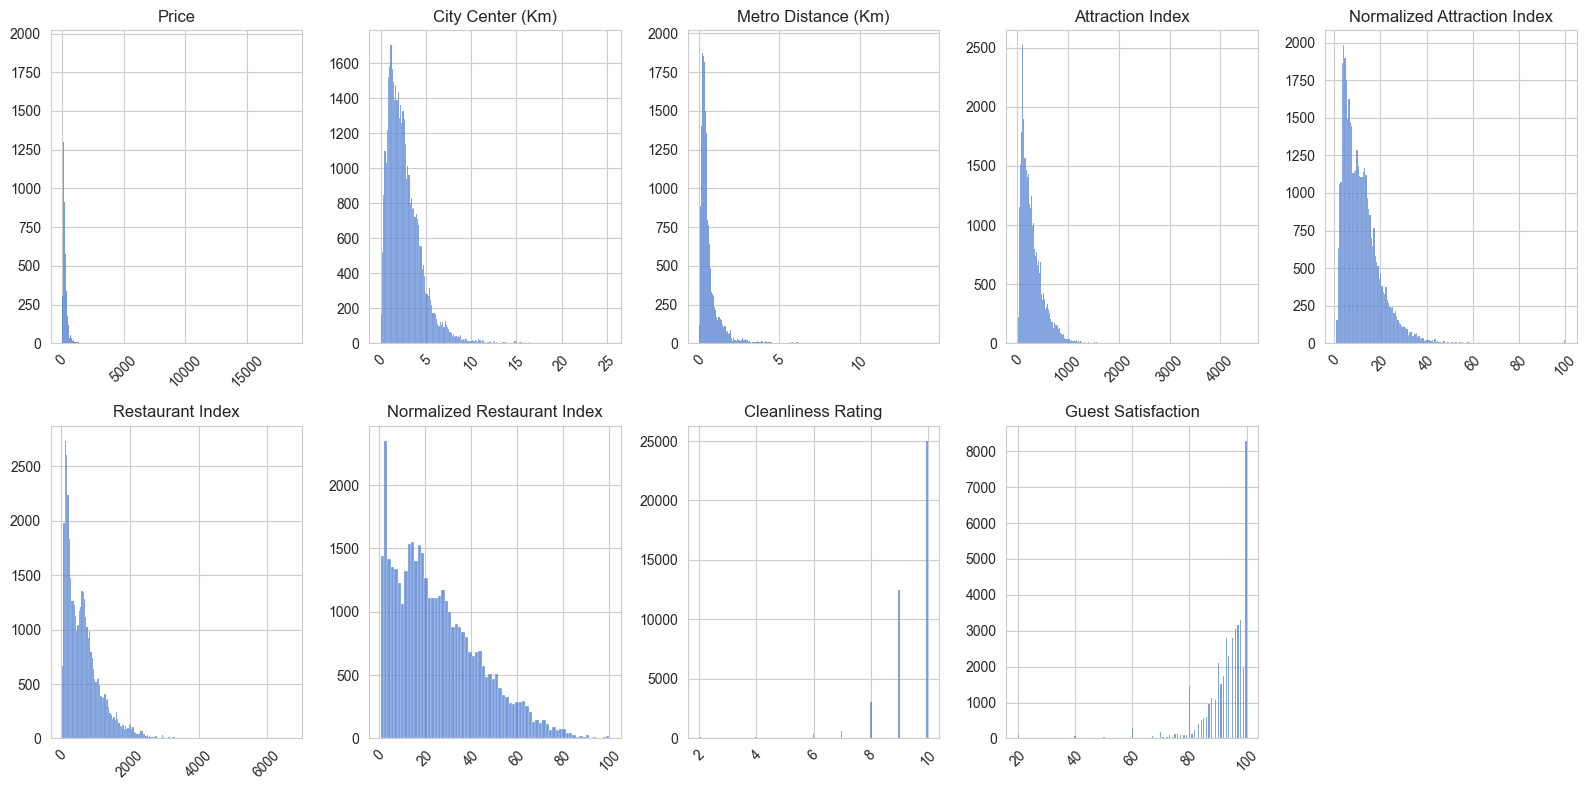

In [9]:
num_cols = ['price', 'city_center_(km)', 'metro_distance_(km)', 'attraction_index', 'normalized_attraction_index', 
            'restaurant_index', 'normalized_restaurant_index', 'cleanliness_rating', 'guest_satisfaction']

plt.figure(figsize=(16,8))

for i, column in enumerate(num_cols):
    plt.subplot(2,5,i+1)
    sns.histplot(data=airbnb, x=column)
    col_title = column.replace('_', ' ').title()
    plt.title(col_title)
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()


There's primarily right-skewed distributions, and a left-skewed distribution for `cleanliness` and `guest satisfaction`. We'll want to scale these values using the min-max scale to maintain the range of values. This also means `normalized_attraction_index` and `normalized_restaurant_index` are likely better predictors

In [10]:
airbnb[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
price,41714.0,260.094423,279.408493,34.779339,144.016085,203.819274,297.373358,18545.450280
city_center_(km),41714.0,2.679792,1.996684,0.015045,1.275913,2.253237,3.584489,25.284557
metro_distance_(km),41714.0,0.603921,0.706206,0.002301,0.236693,0.391220,0.678702,14.273577
attraction_index,41714.0,293.905990,235.750055,15.152201,124.371614,228.920599,394.000201,4513.563486
normalized_attraction_index,41714.0,11.719658,8.379161,0.926301,5.510735,9.951086,15.467009,100.000000
restaurant_index,41714.0,626.692618,520.644720,19.576924,210.459575,519.583509,860.708156,6696.156772
normalized_restaurant_index,41714.0,25.553590,18.484572,0.592757,11.132052,21.814414,36.821356,100.000000
cleanliness_rating,41714.0,9.442274,0.889173,2.000000,9.000000,10.000000,10.000000,10.000000
guest_satisfaction,41714.0,93.103179,8.141745,20.000000,90.000000,95.000000,98.000000,100.000000


### EDA Observations:
- Our target column of `price` has some heavy outliers -- some of the top luxury options are bound to distort a predictive model. 
- The `normalised_restaurant_index` and `normalised_attraction_index` get closest to a normal distribution, but the fields are generally skewed. 
- The skewness of our featuers make a good case for using a log transform. There's a great conceptual explanation found throughout the responses to this [StackExchange post](https://stats.stackexchange.com/questions/298/in-linear-regression-when-is-it-appropriate-to-use-the-log-of-an-independent-va).
- Ultimately the distributions mirror something close to exponential. A log transform will help stabilize some of the variance we're seeing and make the distributions more normal. 
- `cleanliness_rating` and `guest_satisfaction` have most of their values between 9 and 10, they might create noise for the model as is. 


## 2. Dataset Transformations

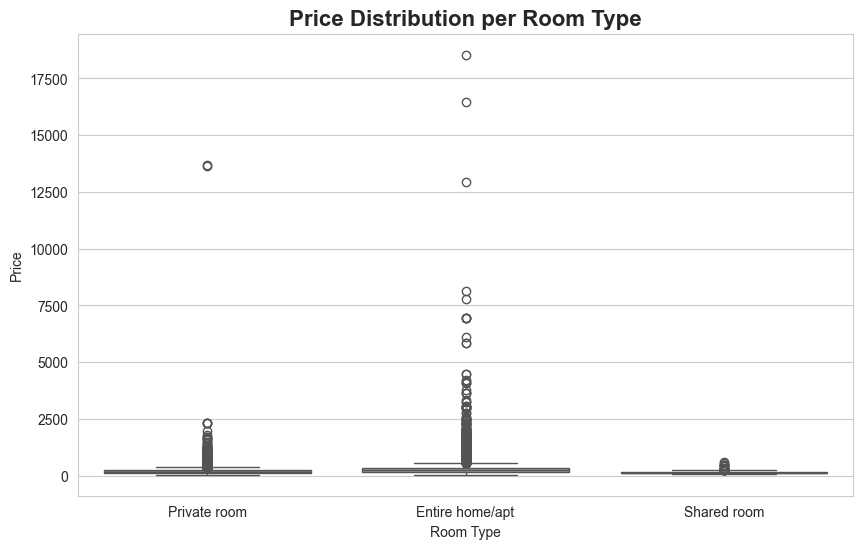

In [11]:
#let's look at the outliers for price first.
plt.figure(figsize=(10,6))
sns.boxplot(x='room_type', y='price', data=airbnb, hue='room_type')
plt.title('Price Distribution per Room Type', fontsize=16, weight='bold')
plt.xlabel('Room Type')
plt.ylabel('Price')
plt.show()

- We want the model to generalize well, and these super expensive listings don't help much with that.
- But we don't want to overcorrect and remove too many rows that provide context into the higher prices.
- let's see the impact of row removal at separate thresholds

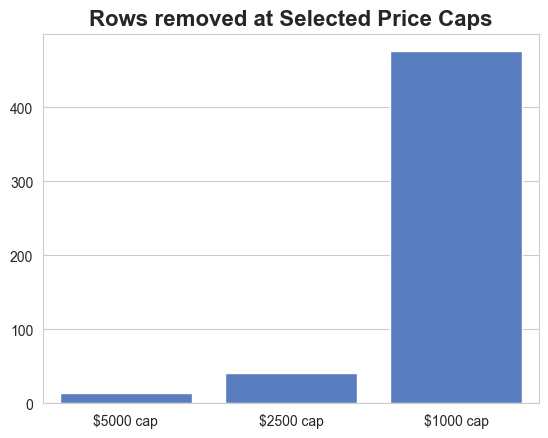

In [12]:
cap_5000 = airbnb[airbnb['price'] <= 5000]
cap_2500 = airbnb[airbnb['price'] <= 2500]
cap_1000 = airbnb[airbnb['price'] <= 1000]

rows_cut = [len(airbnb) - len(df) for df in [cap_5000, cap_2500, cap_1000]]
sns.barplot(data=rows_cut)
plt.title("Rows removed at Selected Price Caps", fontsize=16, weight='bold')
plt.xticks([0, 1, 2], ['$5000 cap', '$2500 cap', '$1000 cap'])

plt.show()

In [13]:
rows_cut

[14, 41, 476]

- I think the $2500 cap makes the most sense for generalization. 
- Most of the super expensive listings are gone, but less than 50 listings are removed. 476 is still quite small at roughly 1% of the overall data, but I think I'd rather maintain some of that context from the $1000-$2500 range.

In [14]:
airbnb = cap_2500

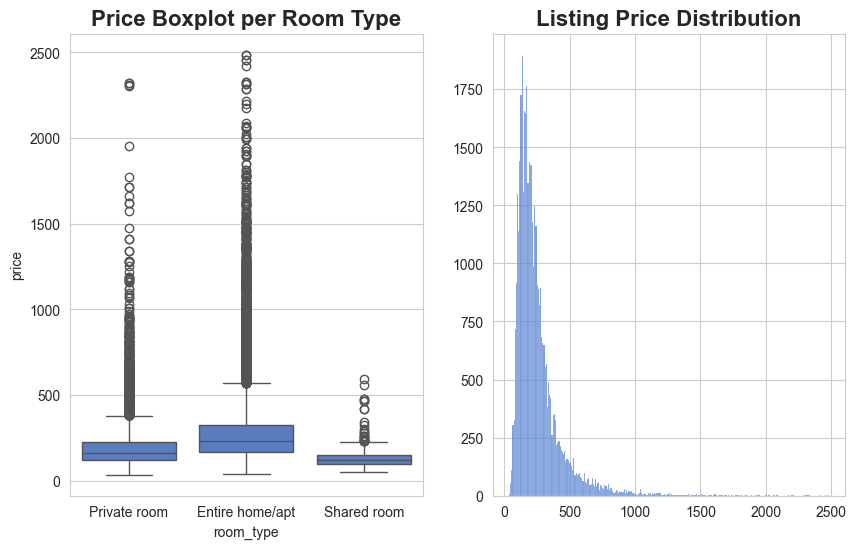

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].set_title('Price Boxplot per Room Type', fontsize=16, weight='bold')
sns.boxplot(x='room_type', y='price', data=cap_2500, ax=ax[0])
sns.histplot(x='price', data=cap_2500, ax=ax[1])
ax[1].set_title('Listing Price Distribution', fontsize=16, weight='bold')
plt.xlabel('')
plt.ylabel('')
plt.show()

- Now the price column has a similar shape as some of the other features. 
- Let's follow up with a log transformation and check distributions there. 

In [16]:
#transform to add 1 to everything - to ensure all values are greater than 1, becasue log is undefines between 0 and 1

for col in num_cols:
    airbnb['log_'+col] = airbnb[col].apply(lambda x: np.log(x+1))
log_df = airbnb[[col for col in airbnb.columns if col.startswith('log_')]]
log_df.head()

,log_price,log_city_center_(km),log_metro_distance_(km),log_attraction_index,log_normalized_attraction_index,log_restaurant_index,log_normalized_restaurant_index,log_cleanliness_rating,log_guest_satisfaction
0,5.273172,1.795579,1.263952,4.378149,1.642236,4.597681,2.060064,2.397895,4.543295
1,5.844257,0.397695,0.214631,6.449168,3.538673,6.731353,4.083333,2.197225,4.454347
2,5.580112,1.909292,1.537216,4.334357,1.606615,4.568371,2.034274,2.302585,4.477337
3,6.074264,0.325601,0.364557,6.203087,3.300239,6.775404,4.126708,2.302585,4.510860
4,6.187346,0.434854,0.276641,6.316858,3.410247,6.704789,4.057191,2.397895,4.595120


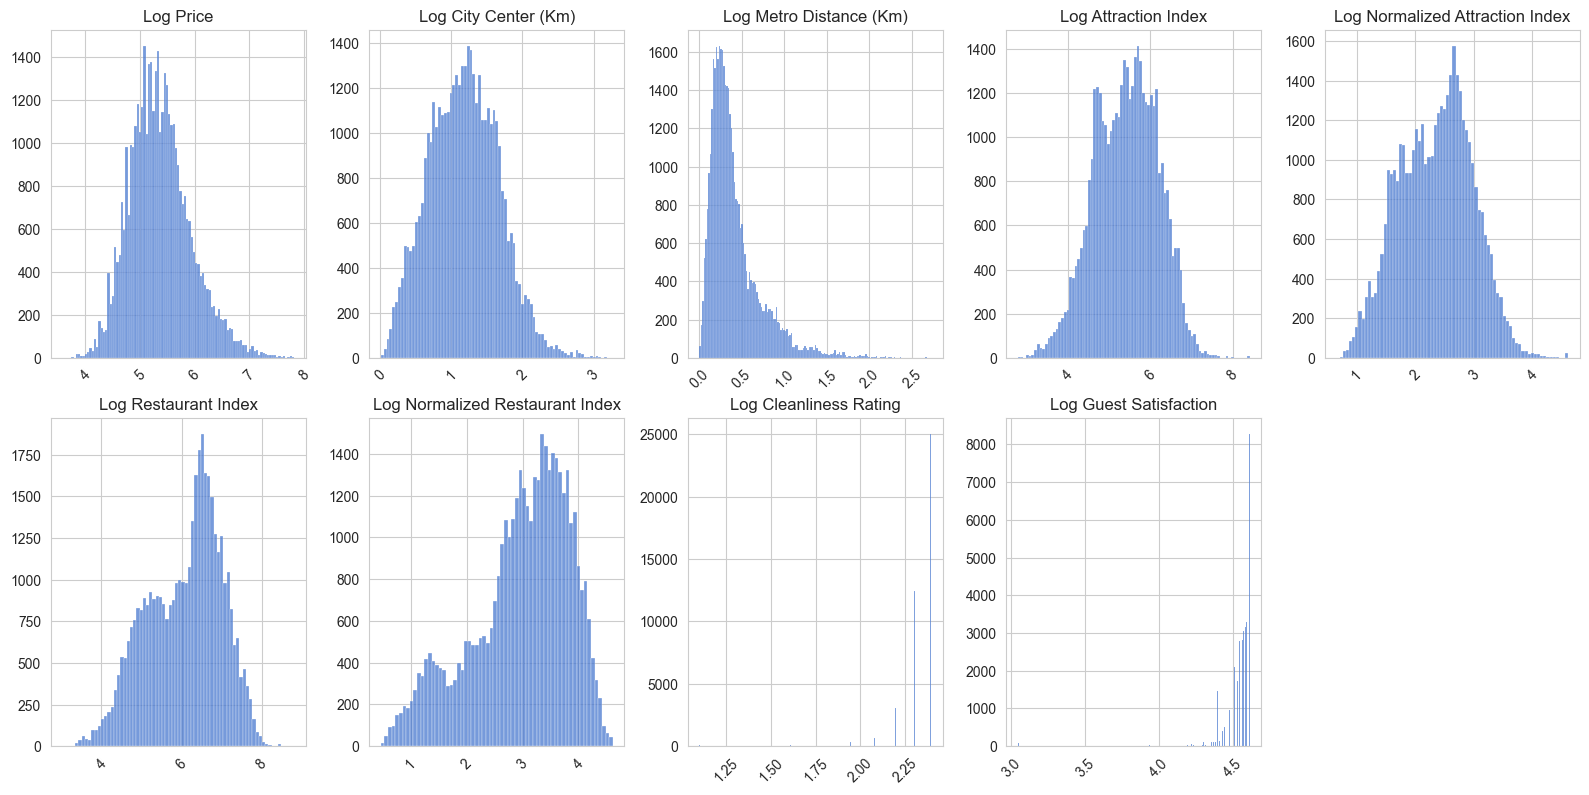

In [17]:
plt.figure(figsize=(16,8))

for i, column in enumerate(log_df.columns):
    plt.subplot(2,5,i+1)
    sns.histplot(data=log_df, x=column)
    col_title = column.replace('_', ' ').title()
    plt.title(col_title)
    plt.xticks(rotation=45)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

- These distributions look much nicer and help meet assumptions the Pearson Correlation Coefficient. 
- From here it seems the log transform will work better than the provided normalized form of restaurant and attraction index. 
- There's still a better way to deal with cleanliness and satisfaction. Those distributions are closer to discrete values than they are continuous.
- We can also look at person capacity and bedrooms for potential transformations

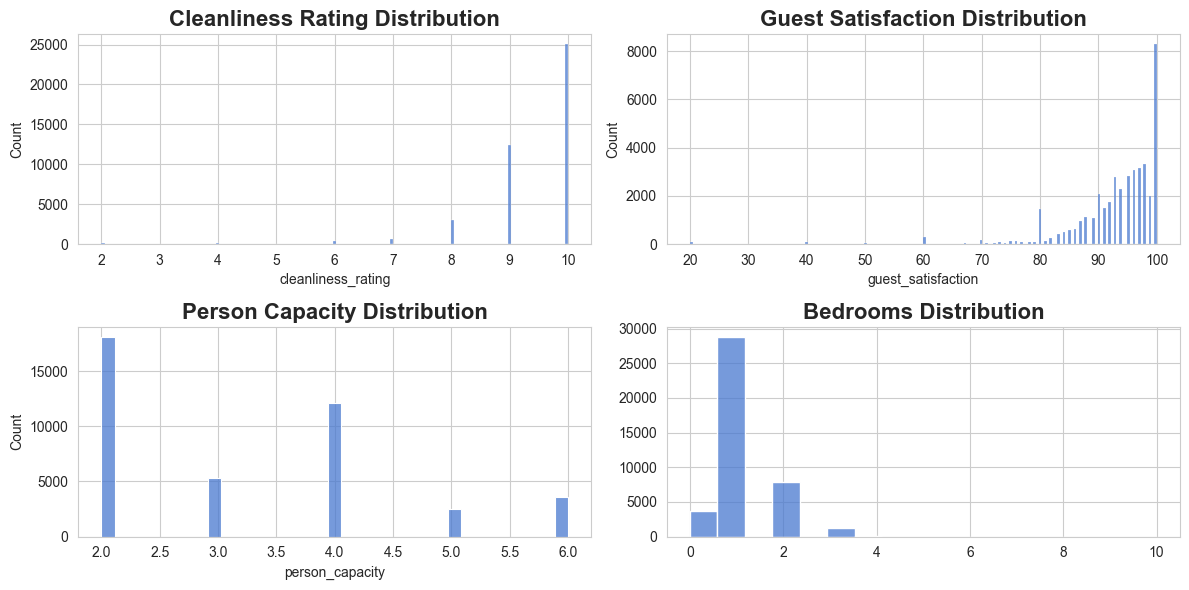

In [18]:
#let's check in on the original data for cleanliness and satisfaction
fig, ax = plt.subplots(2, 2, figsize=(12,6))
ax[0,0].set_title('Cleanliness Rating Distribution', fontsize=16, weight='bold')
sns.histplot(x='cleanliness_rating', data=airbnb, ax=ax[0,0])
ax[0,1].set_title('Guest Satisfaction Distribution', fontsize=16, weight='bold')
sns.histplot(x='guest_satisfaction', data=airbnb, ax=ax[0,1])
ax[1,0].set_title('Person Capacity Distribution', fontsize=16, weight='bold')
sns.histplot(x='person_capacity', data=airbnb, ax=ax[1,0])
ax[1,1].set_title('Bedrooms Distribution', fontsize=16, weight='bold')
sns.histplot(x='bedrooms', data=airbnb, ax=ax[1,1])
plt.xlabel('')
plt.ylabel('')
fig.tight_layout()
plt.show()

- Since the bulk of the data is in that 9-10 or 90-100 range for `cleanliness` and `guest satisfaction`, let's opt to create a binary column for whether that score is 90+ or not.
- With `person_capacity` and `bedrooms`, we can set the cutoff at 2 people and 1 bedroom.

In [19]:
#gotta set these independently because they have unique thresholds.

airbnb['is_clean'] = 1
airbnb.loc[airbnb['cleanliness_rating'] < 9, 'is_clean'] = 0

airbnb['is_satisfied'] = 1
airbnb.loc[airbnb['guest_satisfaction'] < 90, 'is_satisfied'] = 0

airbnb['has_3+_people'] = 1
airbnb.loc[airbnb['person_capacity'] < 3, 'has_3+_people'] = 0

airbnb['has_2+_bedroom'] = 1
airbnb.loc[airbnb['bedrooms'] < 2, 'has_2+_bedroom'] = 0

airbnb['is_weekend'] = 1
airbnb.loc[airbnb['day'] == 'Weekday', 'is_weekend'] = 0

print(airbnb['is_satisfied'].value_counts(), '\n')
print(airbnb['is_clean'].value_counts(), '\n')
print(airbnb['has_3+_people'].value_counts(), '\n')
print(airbnb['has_2+_bedroom'].value_counts(),'\n')
print(airbnb['is_weekend'].value_counts(),'\n')

is_satisfied
1    32977
0     8696
Name: count, dtype: int64 

is_clean
1    37446
0     4227
Name: count, dtype: int64 

has_3+_people
1    23556
0    18117
Name: count, dtype: int64 

has_2+_bedroom
0    32531
1     9142
Name: count, dtype: int64 

is_weekend
0    20865
1    20808
Name: count, dtype: int64 



In [20]:
#the last thing we can do is create dummy columns for the room types & cities
cities = pd.get_dummies(airbnb['city'], prefix='city').astype(int)
rooms = pd.get_dummies(airbnb['room_type'], prefix='room').astype(int)
airbnb = pd.concat([airbnb, cities, rooms], axis=1)
airbnb.describe().T

,count,mean,std,min,25%,50%,75%,max
price,41673.0,254.916073,188.605383,34.779339,144.016085,203.399341,296.812190,2486.584023
shared_room,41673.0,0.007583,0.086750,0.000000,0.000000,0.000000,0.000000,1.000000
private_room,41673.0,0.315120,0.464569,0.000000,0.000000,0.000000,1.000000,1.000000
person_capacity,41673.0,3.236124,1.298641,2.000000,2.000000,3.000000,4.000000,6.000000
superhost,41673.0,0.279605,0.448811,0.000000,0.000000,0.000000,1.000000,1.000000
multiple_rooms,41673.0,0.295371,0.456215,0.000000,0.000000,0.000000,1.000000,1.000000
business,41673.0,0.341204,0.474119,0.000000,0.000000,0.000000,1.000000,1.000000
cleanliness_rating,41673.0,9.442157,0.889385,2.000000,9.000000,10.000000,10.000000,10.000000
guest_satisfaction,41673.0,93.100209,8.143539,20.000000,90.000000,95.000000,98.000000,100.000000
bedrooms,41673.0,1.164639,0.635873,0.000000,1.000000,1.000000,1.000000,10.000000


In [21]:
#removing duplicative columns
cols_to_drop = ['day', 'room_type', 'room_Private room', 'room_Shared room', 'multiple_rooms']
airbnb.drop(columns=cols_to_drop, axis=1, inplace=True)

## 3. Feature Engineering

We did a little bit of this with the binary fields, I'd like to try some other variations of field combinations.

Let's try these out: 

- person_capacity_bedrooms: `person_capacity` * `bedrooms`
- attraction_restaurant_index: `attraction_index` * `restaurant_index` (not the normalized ones)
- city_metro_km2: `city_center` * `metro_distance` 
- metro_city_ratio: ratio of `metro distance` to `city center`
- metro_city_diff: difference between `metro distance` and `city center`. 
- X_city_avg_diff: difference between `guest_satisfaction`, `cleanliness`, `attraction_index`, `restaurant_index` and the average for that city.

In [22]:
#generate avg values for each city
airbnb_grouped = airbnb.groupby('city').agg( 
    avg_cleanliness=('cleanliness_rating', 'mean'),
    avg_attraction=('attraction_index', 'mean'),
    avg_restaurant=('restaurant_index', 'mean'),
    avg_satisfaction=('guest_satisfaction', 'mean')
    ).reset_index()

#now to get the difference for each listing
airbnb = pd.merge(airbnb, airbnb_grouped, on='city')

avg_cols = airbnb.filter(like='avg').columns
avg_diff_dict = dict(zip(avg_cols, ['cleanliness_rating', 'attraction_index', 'restaurant_index', 'guest_satisfaction']))

for k, v in avg_diff_dict.items():
    airbnb[k+'_diff'] = airbnb[v] - airbnb[k]
    #after we get the average difference, we don't need the city avg by itself
    airbnb.drop(k, axis=1, inplace=True)

#we have a new set of avg_columns now after getting the differences
avg_cols = airbnb.filter(like='avg').columns
airbnb[avg_cols].head()

,avg_cleanliness_diff,avg_attraction_diff,avg_restaurant_diff,avg_satisfaction_diff
0,0.5353,-190.321876,-237.381081,-1.491296
1,-1.4647,362.164123,501.645780,-9.491296
2,-0.4647,-193.736378,-240.248022,-7.491296
3,-0.4647,224.260280,539.398121,-4.491296
4,0.5353,283.818070,479.670763,3.508704


I think we should treat these like the normalized restaurant & attraction fields -- get them in a 0-100 range then get an associated log scale of that normalization.

In [23]:
#that was the last action that needed the city column
airbnb.drop('city', axis=1, inplace=True)

In [24]:
def get_normal_log(col_list: Union[float, int], df=airbnb): #log_col, log_normalized_col
    """Creates 2 new columns for each column passed into it. Assumes list of numeric cols
    Negatives are ok because the minmax application happens first"""
    for col in col_list:
        df['normalized_'+col] = ((df[col] - df[col].min()) / 
                                    (df[col].max() - df[col].min()))
        df['log_normalized_'+col] = df['normalized_'+col].apply(lambda x: np.log(x+1))

get_normal_log(avg_cols)

In [25]:
#the other new stuff is easier to set up. 
airbnb['person_capacity_bedrooms'] = airbnb['person_capacity'] * airbnb['bedrooms']
airbnb['attraction_restaurant_index'] = airbnb['attraction_index'] * airbnb['restaurant_index']
airbnb['city_metro_km2'] = airbnb['city_center_(km)'] * airbnb['metro_distance_(km)']
airbnb['metro_city_ratio'] = airbnb['metro_distance_(km)'] / airbnb['city_center_(km)']

#let's do the same normalization + log transformation from above. 
new_cols = ['person_capacity_bedrooms', 'attraction_restaurant_index', 'city_metro_km2', 'metro_city_ratio']
get_normal_log(new_cols)

#also want to get the cols log separately -- they shouldn't be negative
for col in new_cols:
    airbnb['log_'+col] = airbnb[col].apply(lambda x: np.log(x+1))

In [26]:
#how many fields do we have now? 
airbnb.columns

Index(['price', 'shared_room', 'private_room', 'person_capacity', 'superhost',
       'business', 'cleanliness_rating', 'guest_satisfaction', 'bedrooms',
       'city_center_(km)', 'metro_distance_(km)', 'attraction_index',
       'normalized_attraction_index', 'restaurant_index',
       'normalized_restaurant_index', 'log_price', 'log_city_center_(km)',
       'log_metro_distance_(km)', 'log_attraction_index',
       'log_normalized_attraction_index', 'log_restaurant_index',
       'log_normalized_restaurant_index', 'log_cleanliness_rating',
       'log_guest_satisfaction', 'is_clean', 'is_satisfied', 'has_3+_people',
       'has_2+_bedroom', 'is_weekend', 'city_Amsterdam', 'city_Athens',
       'city_Barcelona', 'city_Berlin', 'city_Budapest', 'city_Lisbon',
       'city_Paris', 'city_Rome', 'city_Vienna', 'room_Entire home/apt',
       'avg_cleanliness_diff', 'avg_attraction_diff', 'avg_restaurant_diff',
       'avg_satisfaction_diff', 'normalized_avg_cleanliness_diff',
       'log_

## 4. Feature Selection 

We've got a ton of features now, some of them overlap in what information they provide. 

Let's start with two correlations plots -- continuous log values and continuous regular values

<Axes: >

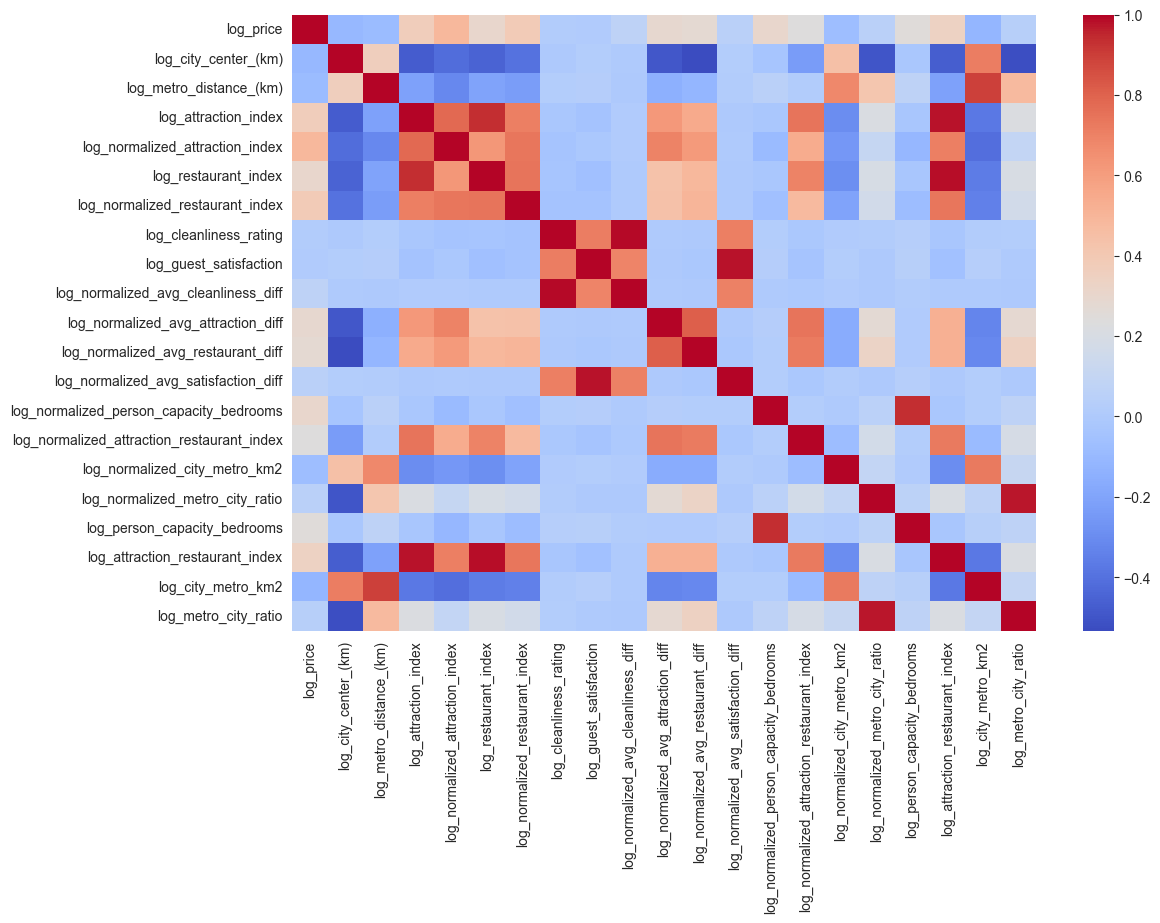

In [27]:
#resetting this since we added once
log_df = airbnb[[col for col in airbnb.columns if col.startswith('log_')]]
log_corr = log_df.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(log_corr, cmap='coolwarm')

<Axes: >

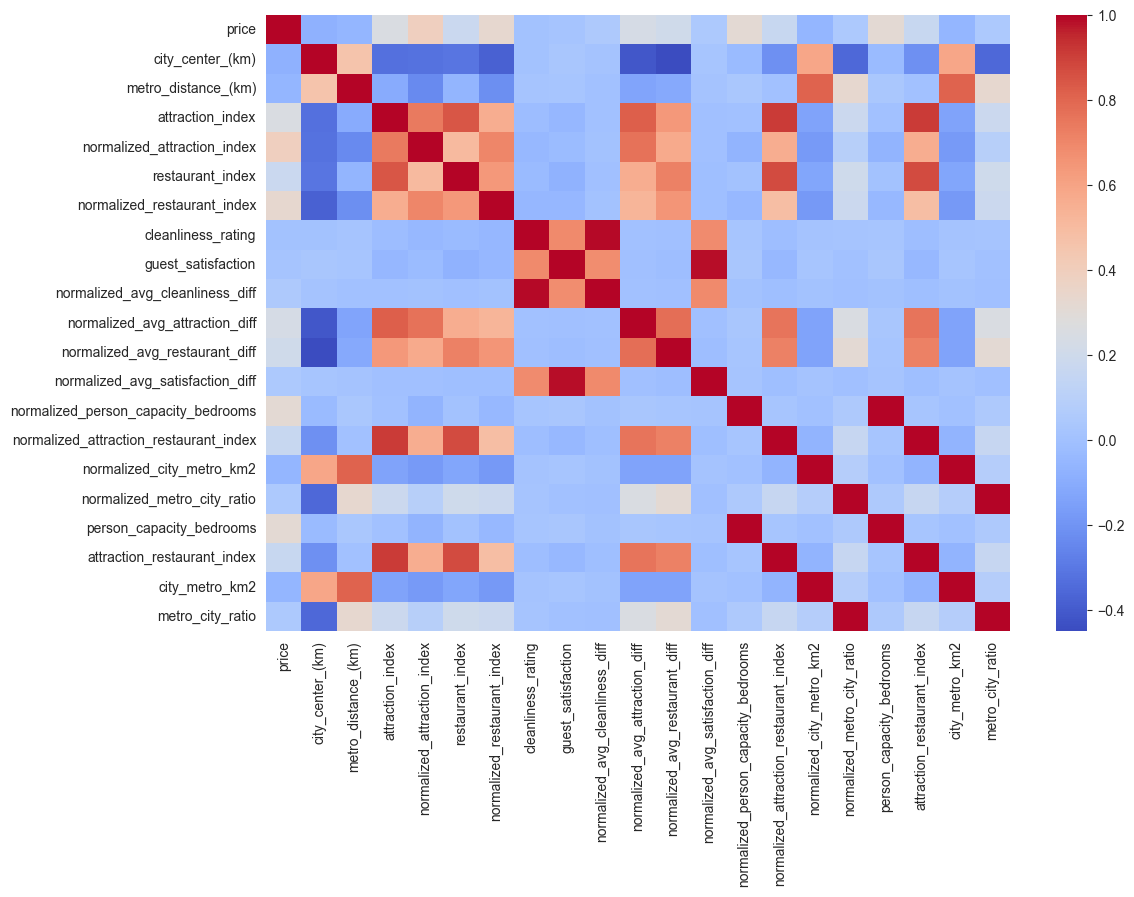

In [28]:
non_log_df = airbnb[[col.replace('log_', '') for col in log_df.columns]]
reg_corr = non_log_df.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(reg_corr, cmap='coolwarm')

- My first reaction is there's potential for multicolinearity to disrupt the model between the `attraction` and `restaurant` fields.
- The log versions, specifically log normalized versions appear to have the strongest relationship with price. 

In [29]:
reg_corr['price'].abs().sort_values(ascending=False)


price                                     1.000000
normalized_attraction_index               0.392532
normalized_restaurant_index               0.327440
normalized_person_capacity_bedrooms       0.309464
person_capacity_bedrooms                  0.309464
attraction_index                          0.254558
normalized_avg_attraction_diff            0.230811
normalized_avg_restaurant_diff            0.205233
restaurant_index                          0.178548
normalized_attraction_restaurant_index    0.163143
attraction_restaurant_index               0.163143
city_center_(km)                          0.079388
metro_distance_(km)                       0.057364
city_metro_km2                            0.054474
normalized_city_metro_km2                 0.054474
normalized_avg_cleanliness_diff           0.051382
metro_city_ratio                          0.045853
normalized_metro_city_ratio               0.045853
normalized_avg_satisfaction_diff          0.043995
guest_satisfaction             

In [30]:
log_corr['log_price'].abs().sort_values(ascending=False)

log_price                                     1.000000
log_normalized_attraction_index               0.486537
log_normalized_restaurant_index               0.383614
log_attraction_index                          0.369454
log_attraction_restaurant_index               0.337955
log_normalized_person_capacity_bedrooms       0.303615
log_restaurant_index                          0.301943
log_normalized_avg_attraction_diff            0.292851
log_normalized_avg_restaurant_diff            0.278848
log_person_capacity_bedrooms                  0.249778
log_normalized_attraction_restaurant_index    0.238281
log_city_metro_km2                            0.119496
log_city_center_(km)                          0.105565
log_metro_distance_(km)                       0.085207
log_normalized_city_metro_km2                 0.074994
log_normalized_avg_cleanliness_diff           0.068339
log_normalized_avg_satisfaction_diff          0.052729
log_normalized_metro_city_ratio               0.052390
log_metro_

We can proceed with the log versions & remove more after investigating multicolinearity. 

In [31]:
airbnb.drop(columns=non_log_df.columns, axis=1, inplace=True)

We can set a threshold between columns as .7 between columns -- and between the results, we should only choose one. 

In [32]:
thresh = 0.7
#lets get correlations for the whole df
corr_df = airbnb.corr(numeric_only=True).abs()
corr_log_price = corr_df['log_price']

def find_multi_corr(corr_df, thresh=thresh) -> list[str,str]:
    """Runs a set of instructions to extract columns beyond a set threshold of correlation"""
    correlated_pairs = []
    for i in range(len(corr_df.columns)):
        #this ensures we stay in the lower triangle of the big corr matrix
        for j in range(i):
            p = corr_df.iloc[i,j]
            if abs(p) > thresh:
                correlated_pairs.append((corr_df.columns[i], corr_df.columns[j]))
    return correlated_pairs

#there's overlap in the correlated pairs and a lot of them, so let's get a set of cols to drop
#so let's choose the column to drop that has a lower correlation with price


#dangerous to use a while loop here - but we want to repeat until find_multi_corr returns []
while True:
    to_drop = set()

    pairs = find_multi_corr(corr_df)
    
    if not pairs:
        break
    
    for col1, col2 in pairs:
        if col1 not in to_drop and col2 not in to_drop:
            if corr_log_price[col1] < corr_log_price[col2]:
                to_drop.add(col1)
            else:
                to_drop.add(col2)
    
    #reset the dfs on each iteration
    airbnb = airbnb.drop(airbnb[list(to_drop)], axis=1)
    corr_df = airbnb.corr(numeric_only=True).abs()  
#now how many columns? 
len(airbnb.columns)

23

<Axes: >

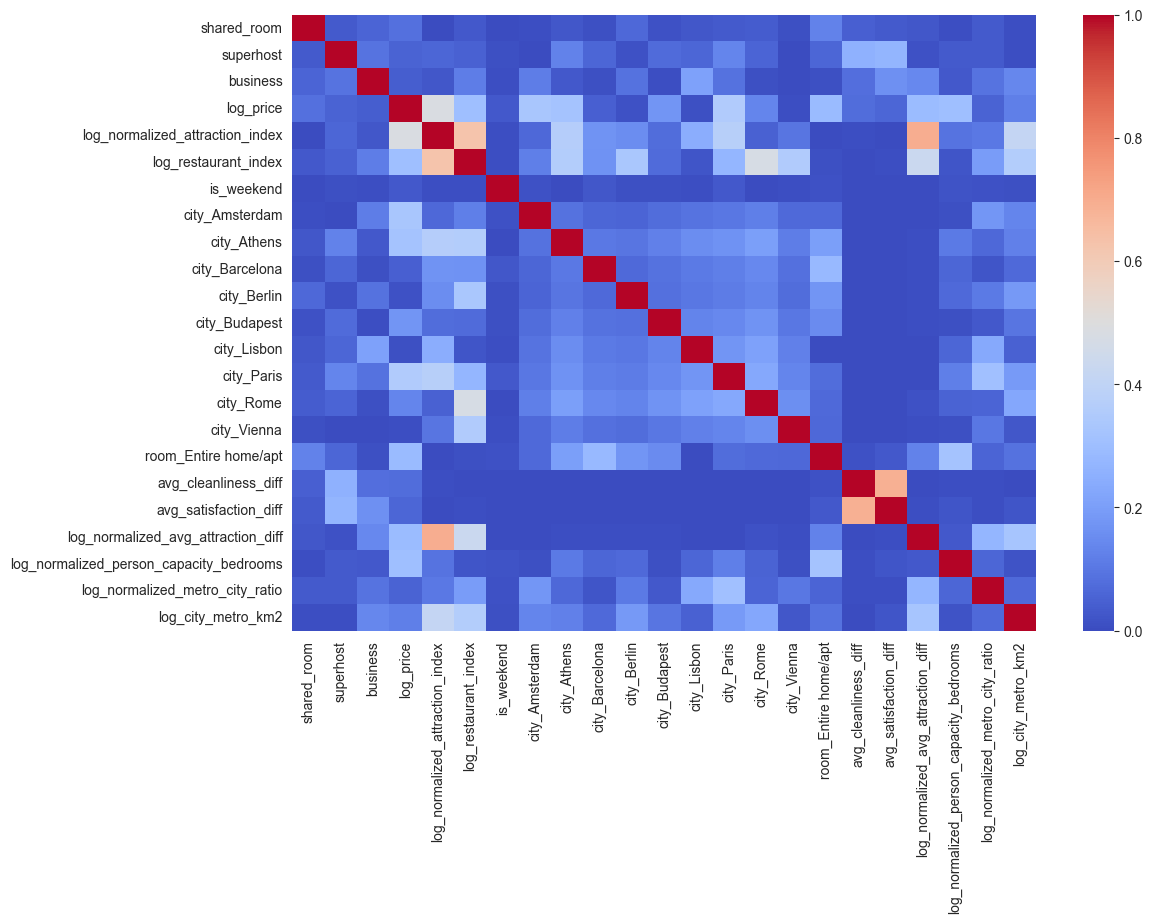

In [33]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_df, cmap='coolwarm')

For the binary fields we can compare with log price in two ways:
- A t test -- the `log_price_field` meets the assumption of normality as shown in the histogram of the field. We can use this to compare the means from the two binary groups to see if there's a difference in `log_price`
- Point-Biserial Correlation -- which allows for inspecting correlation with binary fields. The previous correlation plots are better suited for continuous variables. 

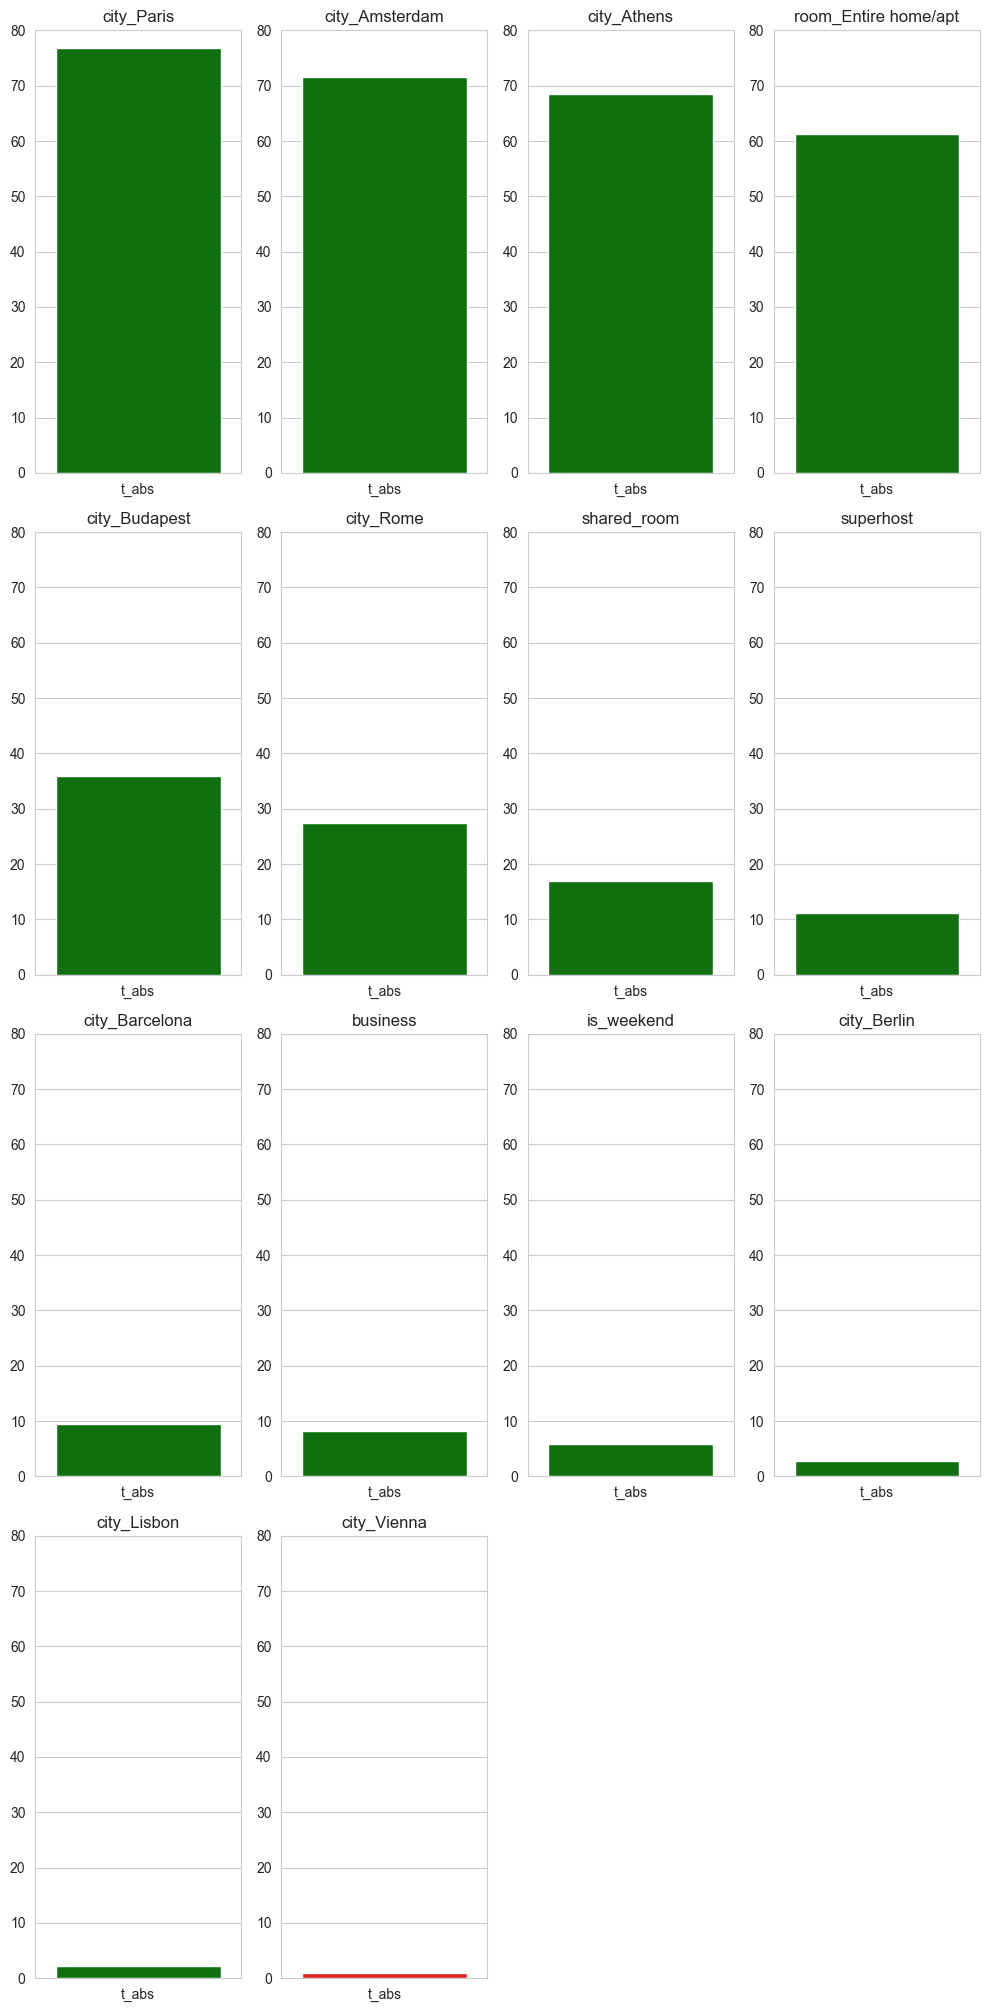

In [34]:
bin_cols = [col for col in airbnb.columns if airbnb[col].nunique() == 2]
bin_cols.append('log_price')
bin_df = airbnb[bin_cols]

results = []

for col in bin_cols:
    if col != 'log_price':
        group_0 = bin_df[bin_df[col] == 0]['log_price']
        group_1 = bin_df[bin_df[col] == 1]['log_price']
        t_statistic, p_value = ttest_ind(group_0, group_1)
        results.append([col, t_statistic, p_value])

results_df = pd.DataFrame(results, columns=['field', 't_statistic', 'p_value'])

#difference matters more so than the increase/decrease
#we can take absolute value of that t statistic
results_df['t_abs'] = results_df['t_statistic'].abs()


results_df = results_df.sort_values('t_abs', ascending=False)

fig, axs = plt.subplots(5, 4, figsize=(10, 25)) 
axs = axs.flatten()

for i, row in enumerate(results_df.itertuples()):
    #the row[#] is pulled from the itertuples object -- which includes the index at row[0]
    color = 'green' if row[3] < 0.05 else 'red'
    sns.barplot(x=['t_abs'], y=[row[4]], ax=axs[i], color=color)
    axs[i].set_title(row[1]) 
    axs[i].set_ylim(0,80) 

#this removes that hanging plot at the end
if len(results_df) < len(axs):
    for i in range(len(results_df), len(axs)):
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


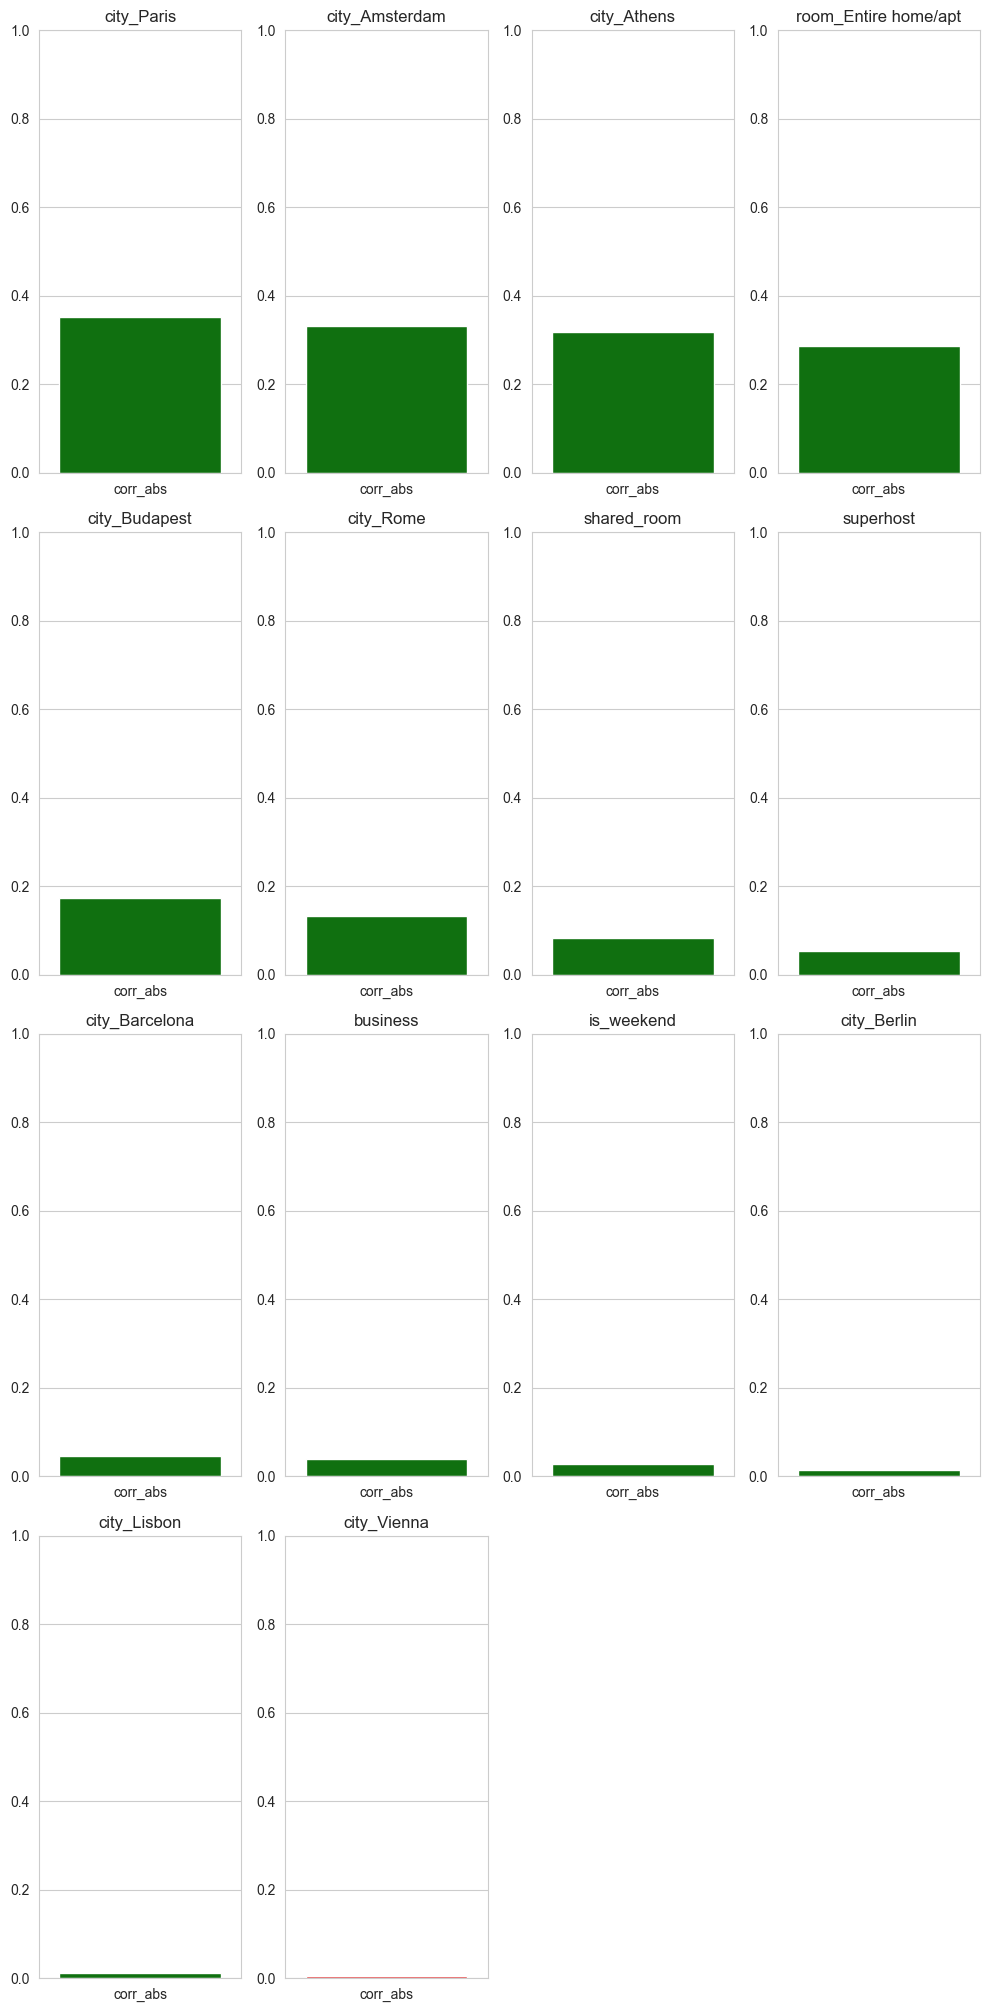

In [35]:
corr_results = []

for col in bin_cols:
    if col != 'log_price':
        correlation, p_value = pointbiserialr(bin_df[col], bin_df['log_price'])
        corr_results.append([col, correlation, p_value])

corr_results_df = pd.DataFrame(corr_results, columns=['field', 'correlation', 'p_value'])

#difference matters more so than the increase/decrease
#we can take absolute value of that t statistic
corr_results_df['corr_abs'] = corr_results_df['correlation'].abs()
corr_results_df = corr_results_df.sort_values('corr_abs', ascending=False)

fig, axs = plt.subplots(5, 4, figsize=(10, 25)) 
axs = axs.flatten()

for i, row in enumerate(corr_results_df.itertuples()):
    #the row[#] is pulled from the itertuples object -- which includes the index at row[0]
    color = 'green' if row[3] < 0.05 else 'red'
    sns.barplot(x=['corr_abs'], y=[row[4]], ax=axs[i], color=color)
    axs[i].set_title(row[1]) 
    axs[i].set_ylim(0,1)

#this removes that hanging plot at the end
if len(corr_results_df) < len(axs):
    for i in range(len(corr_results_df), len(axs)):
        fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

- Results are pretty much the same in terms of the order of fields.  
- The fields colored in green rejected the null hypothesis that there is no difference between the average price when the field = 0 vs. when the field = 1.
- It's really just `city_Vienna` that we can exclude on these metrics. It showed low correlation and failed to reject the null hypothesis for the t test.
- I would have expected weekend to have more impact than it did, but it seems to have little explanatory power on price.

In [36]:
corr_df['log_price'].sort_values(ascending=False)

log_price                                  1.000000
log_normalized_attraction_index            0.486537
city_Paris                                 0.351863
city_Amsterdam                             0.331178
city_Athens                                0.318119
log_normalized_person_capacity_bedrooms    0.303615
log_restaurant_index                       0.301943
log_normalized_avg_attraction_diff         0.292851
room_Entire home/apt                       0.287149
city_Budapest                              0.173573
city_Rome                                  0.133456
log_city_metro_km2                         0.119496
shared_room                                0.082619
avg_cleanliness_diff                       0.074365
avg_satisfaction_diff                      0.059745
superhost                                  0.054419
log_normalized_metro_city_ratio            0.052390
city_Barcelona                             0.046666
business                                   0.040318
is_weekend  

Let's set up 3 datasets to train models. 
- as is, with all features
- the top half of features based on the absolute value correlation with `log_pice` shown above. 
- the top 25% of features on the same criteria

In [37]:
col_order = corr_df['log_price'].sort_values(ascending=False).index

#divide n_features, starting at 1 to exclude the target log_price
#we do want the target in the subset dataframes though, hence the plus 1
#this gets us the top half/quarter of features excluding price

top_half = int(len(col_order[1:])/2)+1
top_quarter = int(len(col_order[1:])/4)+1

top_half_df = airbnb[col_order[:top_half]]
top_quarter_df = airbnb[col_order[:top_quarter]]

top_quarter_df.columns


Index(['log_price', 'log_normalized_attraction_index', 'city_Paris',
       'city_Amsterdam', 'city_Athens',
       'log_normalized_person_capacity_bedrooms'],
      dtype='object')

## 5. Model Training & Evaluation

Let's test the following models here, all are relatively easy to set up: 

- Linear Regression
- Ridge/Lasso/Elastic Regression
- Decision Tree Regression
- Random Forest Regression
- XGBoost
- Support Vector Regression
- Feed Forward Neural Network 


I want to look at RMSE as an evaluation metric because we can interpret it in terms of how many dollars off the model is from the actual price.

We can convert the predicted value and the actual value back to its original form, then compare the error rate there to obtain the same effect as if we were predicting the original price. 

In [38]:
#models to use
lr = LinearRegression()
xgb = XGBRegressor()
rf = RandomForestRegressor()
ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()
dec_tree = DecisionTreeRegressor()
svr = SVR()

#each model combo will have an rmse
model_results = []

#to get an RMSE in terms of regular price vs. log price, we need a custom scorer
def rmse_exp(y_true, y_pred):
    """Calculate RMSE in original price vs. log_price"""
    y_true_exp = np.exp(y_true)
    y_pred_exp = np.exp(y_pred)
    return np.sqrt(mean_squared_error(y_true_exp, y_pred_exp))

rmse_scorer = make_scorer(rmse_exp, greater_is_better=True)


def train(df, df_name, model, model_name):

    X = df.drop('log_price', axis=1)
    y = df['log_price']

    try: 
        #split on standardized random state
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

        scores = cross_val_score(model, X_train, y_train, cv=5, scoring=rmse_scorer)
        val_rmse = scores.mean()

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        test_rmse = rmse_exp(y_test, y_pred)

        results = [model_name, df_name, val_rmse, test_rmse]
        print(results)
        return results
    
    except Exception as e:
        print(f"Error during model training for {model_name}: {e}")

model_list = [(lr, 'linear_regression'), (rf, 'random_forest'), (xgb, 'xgboost'),
              (ridge, 'ridge regression'), (lasso, 'lasso regression'), (elastic, 'elastic regression'), 
              (dec_tree, 'decision tree'), (svr, 'support vector regression')]

df_list = [(airbnb, 'all features'), (top_half_df, 'top half features'), (top_quarter_df, 'top quarter features')]

for model, model_name in model_list:
    for df, df_name in df_list:
        result = train(df, df_name, model, model_name)
        model_results.append(result)

['linear_regression', 'all features', 124.4321281551136, 118.22273502703315]
['linear_regression', 'top half features', 126.60062976428226, 120.5135240280201]
['linear_regression', 'top quarter features', 134.62033253414955, 129.17459538552944]
['random_forest', 'all features', 93.77347332445888, 83.87818981207927]
['random_forest', 'top half features', 95.89540288623643, 88.12500996285077]
['random_forest', 'top quarter features', 128.1794086534142, 122.35400569062529]
['xgboost', 'all features', 104.2482765504576, 96.18712394220684]
['xgboost', 'top half features', 108.75949966949786, 103.4294330535695]
['xgboost', 'top quarter features', 125.35801591013906, 120.59978245948456]
['ridge regression', 'all features', 124.4636935978001, 118.24779878049364]
['ridge regression', 'top half features', 126.63854981591248, 120.54082534652102]
['ridge regression', 'top quarter features', 134.66444424271404, 129.20647355697574]
['lasso regression', 'all features', 193.80454531859297, 189.8229813

In [39]:
#we'll need to set up the NN separately -- it needs a different training process
def train_nn(df, df_name, model_name, 
             epochs=25, batch_size=32, learning_rate=.01):
    X = df.drop('log_price', axis=1)
    y = df['log_price']

    #the input layer needs to have the same number of neurons as features
    model = nn.Sequential(
    nn.Linear(len(X.columns), 12),
    nn.ReLU(),
    nn.Linear(12, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
    )

    try:
        #instead of cross-val scores, we'll create a validation split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0) 

        #resets each split as a tensor
        X_train, X_test, y_train, y_test, X_val, y_val = map(
            lambda x: torch.tensor(x.values, dtype=torch.float32),
            [X_train, X_test, y_train, y_test, X_val, y_val]
        )

        #quick dataloader
        train_dataset = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        loss_func = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

        for epoch in range(epochs):
            for X_batch, y_batch in train_loader:
                #squeeze here is getting the output sizes aligned
                y_pred = model(X_batch).squeeze(1)
                loss = loss_func(y_pred, y_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            #integrating validation
            with torch.no_grad():
                y_val_pred = model(X_val).squeeze(1)
                val_loss = loss_func(y_val_pred, y_val)
                
                if epoch % 5 == 0:
                    print(f'Epoch {epoch}, Val Loss: {val_loss.item()}')

        #on the test dataset
        with torch.no_grad():
            y_test_pred = model(X_test).squeeze(1)
            test_loss = loss_func(y_test_pred, y_test)
            print(f'Test Loss: {test_loss.item()}')

            # gets the RMSE on the same scale
            y_val_pred_orig = np.exp(y_val_pred.detach().numpy())
            y_val_orig = np.exp(y_val.numpy())
            val_rmse = np.sqrt(mean_squared_error(y_val_orig, y_val_pred_orig))

            y_test_pred_orig = np.exp(y_test_pred.detach().numpy())
            y_test_orig = np.exp(y_test.numpy())
            test_rmse = np.sqrt(mean_squared_error(y_test_orig, y_test_pred_orig))

        results = [model_name, df_name, val_rmse, test_rmse]
        print(results)
        return results
    
    except Exception as e:
        print(f"Error during model training for {model_name}: {e}")



for df, df_name in df_list:
    result = train_nn(df, df_name, 'neural network')
    model_results.append(result)

Epoch 0, Val Loss: 0.17536363005638123
Epoch 5, Val Loss: 0.1400105357170105
Epoch 10, Val Loss: 0.1237986758351326
Epoch 15, Val Loss: 0.10632715374231339
Epoch 20, Val Loss: 0.12836818397045135
Test Loss: 0.10070422291755676
['neural network', 'all features', 123.02152, 114.19555]
Epoch 0, Val Loss: 0.18493153154850006
Epoch 5, Val Loss: 0.11321021616458893
Epoch 10, Val Loss: 0.2328433245420456
Epoch 15, Val Loss: 0.12511269748210907
Epoch 20, Val Loss: 0.11236364394426346
Test Loss: 0.14778900146484375
['neural network', 'top half features', 146.66031, 141.28894]
Epoch 0, Val Loss: 0.1734219193458557
Epoch 5, Val Loss: 0.14682239294052124
Epoch 10, Val Loss: 0.1504938006401062
Epoch 15, Val Loss: 0.14303728938102722
Epoch 20, Val Loss: 0.14386819303035736
Test Loss: 0.14951948821544647
['neural network', 'top quarter features', 139.4258, 134.37975]


In [40]:
results_df = pd.DataFrame(model_results, columns=['model_name', 'dataset', 'avg_cv_rmse', 'test_rmse'])

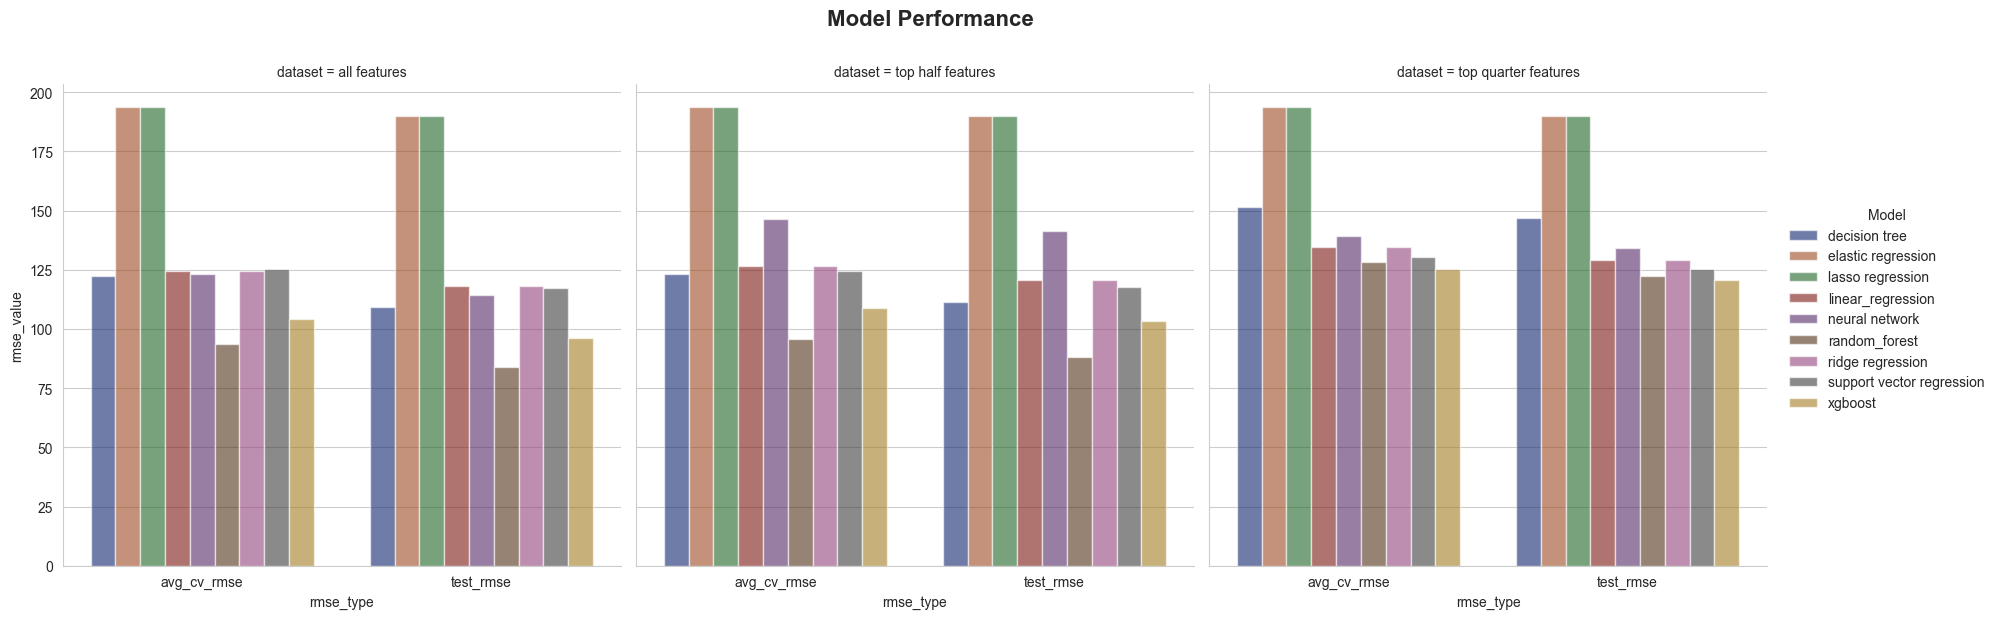

In [41]:
results_melt = results_df.melt(id_vars=['model_name', 'dataset'], 
                               value_vars=['avg_cv_rmse', 'test_rmse'],
                               var_name='rmse_type',
                               value_name='rmse_value')

g = sns.FacetGrid(results_melt, col="dataset", height=6, aspect=1)
g.map(sns.barplot, "rmse_type", "rmse_value", "model_name", 
      errorbar=None, 
      palette="dark", 
      alpha=.6,
      order=['avg_cv_rmse', 'test_rmse'],
      hue_order=results_melt['model_name'].sort_values().unique())

# Adjust the position of the legends and add title
g.add_legend(title="Model")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Model Performance', fontsize=16, weight='bold', y=1.025, x=.47)

plt.show()

## 6. Conclusions

- The random forest model & all available features ends up being the best with a test RMSE of about 84. Given that the average price is about $260, being off by $84 is fairly good, but there's certainly room for improvement. 
- The biggest thing that impacted model performance across the board is handling the price outliers -- not doing anything to the outliers increased RMSE by about 100-150. 
- It makes sense that a random forest would perform the best, as most of our features had relatively low correlation with price.
- My assumption coming in was that fewer features would increase performance, but the results are showing the opposite. Maybe I could have kept even more features than what I excluded? Maybe further feature engineering is the best way to improve performance?
- I didn't do any hyperparameter tuning for some of the more complex models, that has a shot at improving model performance, but it is quite computationally expensive.
- There are no identifiers for the listings. The presence of a `weekend` field makes me think there might be some repeat listings from different days
- I'm also willing to bet there's a seasonality component to price that this dataset doesn't capture. A better price model would incorporate adjustments for seasonality. 
- This is admittedly a very simple neural network. My intent was to cast a wide net on various models without getting too lost in the weeds of deep learning. 